# ENG07042 - Modelagem e Controle
# Exercício  Computacional 2
### Simulação Estacionária e Dinâmica

## Parte 1: Configuração e Geração do Diagrama de Bifurcação

Nesta primeira etapa, o objetivo é mapear como a **concentração estacionária ($C_{A,ss}$)** do reator varia em função da **temperatura da camisa ($T_j$)**.

O código realiza uma varredura numérica utilizando um solucionador de raízes (`scipy.optimize.root`) com múltiplos chutes iniciais para detectar todos os possíveis estados estacionários (estáveis e instáveis). Incluímos um **filtro de resíduos** para descartar soluções numéricas falsas e garantir um gráfico limpo.

### ⚙️ Parâmetros do Sistema
* **Vazão de alimentação ($F$):** $1.1 \, m^3/h$
* **Temperatura de alimentação ($T_f$):** $315.0 \, K$ *(Nota: Como esta temperatura é alta, a região de multiplicidade ocorre em $T_j$ mais baixos)*
* **Volume do reator ($V$):** $1.0 \, m^3$
* **Concentração de entrada ($C_{af}$):** $10.0 \, kmol/m^3$

### 🔍 Parâmetros de Simulação
* **Faixa de $T_j$:** $200 \, K$ a $340 \, K$ (Expandida para capturar a curva em "S" completa)
* **Critério de Convergência:** Resíduo $< 10^{-5}$

Módulos 'cstr_dyn' e 'cstr_dyn_ss' importados com sucesso.

--- Parte 1: Configuração e Parâmetros ---
Parâmetros: F=1.1 m³/h, Tf=315.0 K, V=1.0 m³, caf=10.0 kmol/m³

--- Parte 2: Tarefa 1 - Geração de Dados de Bifurcação ---
Iniciando varredura com filtro de resíduos...


c:\Users\Bruno\Desktop\Arquivos Exercício Computacional Simulação-20251116\Simulacao-em-python-para-reator-CSTR-\cstr_dyn_ss.py:35: RuntimeWarning: overflow encountered in exp
  rate = k0*np.exp(-E_act/(R*Temp))*ca
c:\Users\Bruno\Desktop\Arquivos Exercício Computacional Simulação-20251116\Simulacao-em-python-para-reator-CSTR-\cstr_dyn_ss.py:35: RuntimeWarning: overflow encountered in scalar multiply
  rate = k0*np.exp(-E_act/(R*Temp))*ca


Varredura concluída. 252 pontos válidos encontrados.


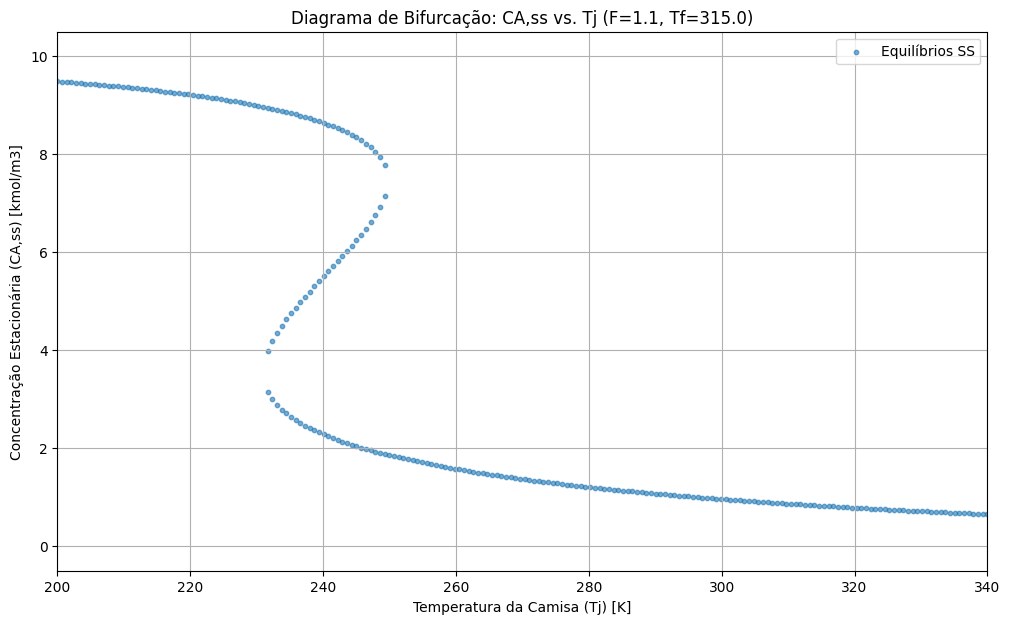

In [1]:
# === Importações de Bibliotecas ===

import matplotlib.pylab as pl
import numpy as np
from scipy.integrate import odeint
import scipy.optimize as scp
import warnings
from cstr_dyn import cstr_dyn
from cstr_dyn_ss import cstr_dyn_ss

# Configuração do Matplotlib
pl.rcParams.update({"mathtext.default": 'regular'})

# Importar as funções dos arquivos .py locais
try:
    from cstr_dyn import cstr_dyn
    from cstr_dyn_ss import cstr_dyn_ss

    print("Módulos 'cstr_dyn' e 'cstr_dyn_ss' importados com sucesso.")
except ImportError:
    print(
        "ERRO: Não foi possível encontrar os arquivos 'cstr_dyn.py' e 'cstr_dyn_ss.py'."
    )
    print("Por favor, salve este script no mesmo diretório que os arquivos fornecidos.")
    exit()


# Configuração do Matplotlib
pl.rcParams.update({"mathtext.default": "regular"})

# === Parte 1: Configuração e Parâmetros ===
print("\n--- Parte 1: Configuração e Parâmetros ---")

# Dados específicos do exercício (SEUS DADOS - NÃO ALTERADOS)
F = 1.1  # m³/h (Vazão de alimentação)
Tf = 315.0  # K (Temperatura de alimentação)
V = 1.0  # m³ (Volume do reator)
caf = 10.0  # kmol/m³ (Concentração de entrada)

print(f"Parâmetros: F={F} m³/h, Tf={Tf} K, V={V} m³, caf={caf} kmol/m³")

# Suprimir avisos de tempo de execução (comuns em 'root' e 'odeint')
warnings.filterwarnings("ignore", "The iteration is not making good progress")
warnings.filterwarnings("ignore", "RuntimeWarning: overflow encountered in exp")

# === Parte 2: Tarefa 1 - Geração de Dados de Bifurcação ===
print("\n--- Parte 2: Tarefa 1 - Geração de Dados de Bifurcação ---")
print("Iniciando varredura com filtro de resíduos...")

# Faixa expandida para pegar o S completo (devido ao Tf=315K)
Tj_range = np.linspace(200.0, 340.0, 200)

# Grade de estimativas
ca_guesses = np.linspace(0.1, 10.0, 20)
T_guesses = np.linspace(300.0, 450.0, 20)

bifurcation_data = []

for Tj_val in Tj_range:
    solutions_for_this_Tj = []
    args_ss = (V, F, caf, Tf, Tj_val)

    for ca_g in ca_guesses:
        for T_g in T_guesses:
            x0 = [ca_g, T_g]

            sol = scp.root(cstr_dyn_ss, x0, args=args_ss, method="hybr")

            # --- FILTRO DE RESÍDUOS (NOVO) ---
            if sol.success:
                # Checa se a solução é verdadeira calculando o erro
                residuo = cstr_dyn_ss(sol.x, V, F, caf, Tf, Tj_val)
                if np.linalg.norm(residuo) < 1e-5:  # Apenas erros minúsculos passam
                    solutions_for_this_Tj.append(sol.x)

    if solutions_for_this_Tj:
        sol_array = np.array(solutions_for_this_Tj)
        sol_rounded = np.round(sol_array, decimals=4)
        unique_equilibria = np.unique(sol_rounded, axis=0)

        for eq in unique_equilibria:
            # Filtro físico (Concentração entre 0 e Caf)
            if 0 <= eq[0] <= caf + 0.1:
                bifurcation_data.append((Tj_val, eq[0], eq[1]))

print(f"Varredura concluída. {len(bifurcation_data)} pontos válidos encontrados.")

# --- Plotagem ---
if bifurcation_data:
    Tj_plot, CA_plot, T_plot = zip(*bifurcation_data)

    pl.figure(figsize=(12, 7))
    pl.scatter(Tj_plot, CA_plot, s=10, alpha=0.6, label="Equilíbrios SS")
    pl.xlabel("Temperatura da Camisa (Tj) [K]")
    pl.ylabel("Concentração Estacionária (CA,ss) [kmol/m3]")
    pl.title(f"Diagrama de Bifurcação: CA,ss vs. Tj (F={F}, Tf={Tf})")

    # Limites ajustados para focar na curva S que apareceu à esquerda
    pl.xlim(200, 340)
    pl.ylim(-0.5, 10.5)

    pl.grid(True)
    pl.legend()
    pl.show()


## Parte 2: Simulação Dinâmica e Diagrama de Plano de Fase

Nesta etapa, selecionamos automaticamente um valor de **Temperatura da Camisa ($T_j$)** que resultou em **3 estados estacionários** na etapa anterior (região de multiplicidade).

O objetivo é visualizar a estabilidade desses pontos. Para isso, simulamos o comportamento dinâmico do reator (`scipy.integrate.odeint`) partindo de diversas **condições iniciais** diferentes para traçar as trajetórias no espaço de estados ($C_A$ vs $T$).

### 📊 Configuração da Análise
* **$T_j$ Selecionado:** Escolhido automaticamente no centro da região de multiplicidade (tipicamente próximo a $240 K$ para os parâmetros atuais).
* **Tempo de Simulação:** $0$ a $10$ horas.
* **Grade de Condições Iniciais:**
    * Concentração ($C_A$): $0$ a $20 \, kmol/m^3$
    * Temperatura ($T$): $200$ a $400 \, K$

### 🏷️ Legenda do Gráfico
* **Linhas Azuis:** Trajetórias dinâmicas do sistema (evolução temporal).
* **Pontos Vermelhos:** Condições iniciais de cada simulação.
* **X Verdes:** Pontos de Equilíbrio (Estados Estacionários) calculados na Parte 1.


--- Parte 3: Tarefa 2 - Geração do Plano de Fase ---
Região de 3 soluções encontrada. Tj selecionado para plano de fase: 240.80 K
Pontos de Equilíbrio (PEs) para Tj=240.80 K:
[[  2.2437 371.7446]
 [  5.6076 340.2389]
 [  8.6056 312.1603]]
Iniciando simulação dinâmica (400 trajetórias)...
Simulação concluída. Plotando camadas de anotação.


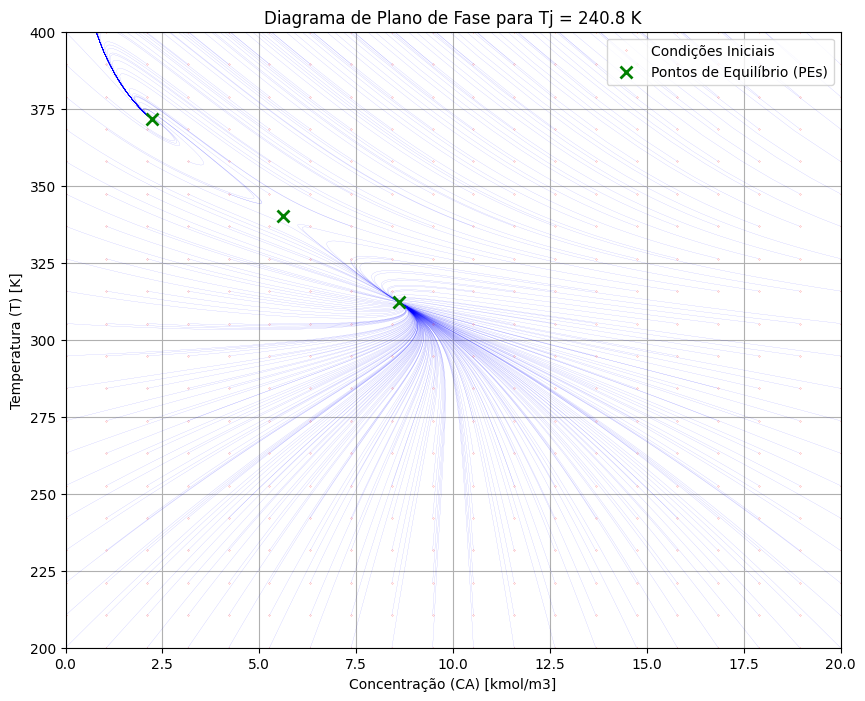


--- Execução Concluída ---


In [2]:
# === Parte 3: Tarefa 2 - Geração do Diagrama de Plano de Fase ===
print("\n--- Parte 3: Tarefa 2 - Geração do Plano de Fase ---")

# --- 3.1 Seleção do Ponto de Operação (Tj) ---
# Encontrar um valor de Tj que tenha 3 soluções
Tj_target = None
if bifurcation_data:
    Tj_plot_array = np.array(Tj_plot)
    # Arredondar para garantir a contagem correta
    Tj_vals, counts = np.unique(np.round(Tj_plot_array, 5), return_counts=True)
    Tj_with_3_solutions = Tj_vals[counts == 3]

    if len(Tj_with_3_solutions) == 0:
        print(
            "AVISO: Nenhuma região com 3 soluções foi encontrada com os parâmetros atuais."
        )
        print(
            "O plano de fase será gerado para um Tj arbitrário (300 K), mas pode não mostrar multiplicidade."
        )
        Tj_target = 300.0  # Valor de fallback
    else:
        # Selecionar um valor central da região de 3 soluções para ficar mais bonito
        idx_center = len(Tj_with_3_solutions) // 2
        Tj_target = Tj_with_3_solutions[idx_center]
        print(
            f"Região de 3 soluções encontrada. Tj selecionado para plano de fase: {Tj_target:.2f} K"
        )
else:
    print("AVISO: Não foi possível executar a Tarefa 1. Usando Tj=300K como fallback.")
    Tj_target = 300.0

# --- 3.2 Identificação dos Pontos de Equilíbrio (PEs) ---
equilibria_points = []
for tj_b, ca_b, t_b in bifurcation_data:
    if np.isclose(tj_b, Tj_target):
        equilibria_points.append([ca_b, t_b])

PEs = np.array(equilibria_points)
if PEs.size > 0:
    print(f"Pontos de Equilíbrio (PEs) para Tj={Tj_target:.2f} K:")
    print(PEs)
else:
    print(
        f"Nenhum Ponto de Equilíbrio (PE) pré-calculado encontrado para Tj={Tj_target:.2f} K."
    )

# --- 3.3 Configuração da Simulação Dinâmica ---
t_span = np.linspace(0, 10.0, 500)  # Vetor de tempo (10 horas)

# Grade de Condições Iniciais (CIs)
ca_0_grid = np.linspace(0, 20, 20)
T_0_grid = np.linspace(200, 400, 20)

args_dyn = (V, F, caf, Tf, Tj_target)

# --- 3.4 Execução da Simulação em Lote e Plotagem (Camada 1) ---
print("Iniciando simulação dinâmica (400 trajetórias)...")
pl.figure(figsize=(10, 8))
ax = pl.subplot(111)

# Inicializar a lista de CIs
CI_list = []

for ca_0 in ca_0_grid:
    for T_0 in T_0_grid:

        ic = [ca_0, T_0]
        CI_list.append(ic)

        # 1. Integrar as EDOs
        sol_dyn = odeint(cstr_dyn, ic, t_span, args=args_dyn)

        C_A_traj = sol_dyn[:, 0]
        T_traj = sol_dyn[:, 1]

        # 2. Plotar Camada 1 (Trajetórias)
        ax.plot(C_A_traj, T_traj, "b-", lw=0.1, alpha=0.5)

print("Simulação concluída. Plotando camadas de anotação.")

# --- 3.5 Visualização do Plano de Fase (Camadas Finais) ---

# Camada 2 (Condições Iniciais)
CI_array = np.array(CI_list)
ax.plot(
    CI_array[:, 0], CI_array[:, 1], "r.", markersize=0.25, label="Condições Iniciais"
)

# Camada 3 (Pontos de Equilíbrio)
if PEs.size > 0:
    ax.plot(
        PEs[:, 0],
        PEs[:, 1],
        "gx",
        markersize=8,
        mew=2,
        label="Pontos de Equilíbrio (PEs)",
    )

# --- 3.6 Formatação Final do Gráfico ---
ax.set_xlabel("Concentração (CA) [kmol/m3]")
ax.set_ylabel("Temperatura (T) [K]")

ax.set_title(f"Diagrama de Plano de Fase para Tj = {Tj_target:.1f} K")

ax.set_xlim(0, 20)
ax.set_ylim(200, 400)

ax.grid(True)
ax.legend()
pl.show()

print("\n--- Execução Concluída ---")